#   Final Project - Retail Data Analytics
## Prediction Poblem - Sales Forecasting


**Data Science** -  **March 29, 2020**

#### SUDIPTI KATWAL

## Data Collection & Cleaning

Data Source:

Kaggle: https://www.kaggle.com/manjeetsingh/retaildataset

In [83]:
# Import Python packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter, CategoricalColorMapper
from bokeh.models.tools import HoverTool
from bokeh.palettes import Spectral6, RdBu3
from bokeh.transform import factor_cmap
import statsmodels.formula.api as smf
import statsmodels.api as sm  
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error
import itertools
import warnings

%matplotlib inline
output_notebook()

Loading BokehJS ...

The following few steps involve importing the data and exploring the dataset

In [7]:
# Imported first file in the dataset

sales = pd.read_csv("D:/Learning/Brainstation Data Science/Project/retaildataset\sales data-set.csv")
sales.shape

(421570, 5)

In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [9]:
sales.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [10]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [11]:
# Imported the second file in the dataset

stores = pd.read_csv("D:/Learning/Brainstation Data Science/Project/retaildataset\stores data-set.csv")
stores.shape

(45, 3)

In [12]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [13]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [14]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [94]:
# Merged sales & stores datasets into a unique dataframe using a left join with 'Stores' as the unique key

df = pd.merge(sales, stores, how = 'left', on = 'Store')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,05/02/2010,24924.50,False,A,151315
1,1,1,12/02/2010,46039.49,True,A,151315
2,1,1,19/02/2010,41595.55,False,A,151315
3,1,1,26/02/2010,19403.54,False,A,151315
4,1,1,05/03/2010,21827.90,False,A,151315


In [16]:
# Checked the data types for all columns in the dataset 

df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

In [17]:
# Changed the data type for 'Date' column to datetime

df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
dtype: object

In [18]:
df.describe()

,Store,Dept,Weekly_Sales,Size
count,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739
std,12.785297,30.492054,22711.183519,60980.583328
min,1.000000,1.000000,-4988.940000,34875.000000
25%,11.000000,18.000000,2079.650000,93638.000000
50%,22.000000,37.000000,7612.030000,140167.000000
75%,33.000000,74.000000,20205.852500,202505.000000
max,45.000000,99.000000,693099.360000,219622.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 7 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 22.9+ MB


In [20]:
# There are 45 unique stores, 81 Departments and 3 Types of Stores

df.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
Type                 3
Size                40
dtype: int64

In [21]:
# No null values found in the data

df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
dtype: int64

In [22]:
# No duplicate values found in the data

df[['Date','Store','Dept','Weekly_Sales']].duplicated().sum()

0

In [23]:
# There are 3 different 'Types' of Stores

df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [24]:
# Transformed the 'IsHoliday' column to int data type from boolean

df['IsHoliday'] = df['IsHoliday'].astype(int)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-05-02,24924.50,0,A,151315
1,1,1,2010-12-02,46039.49,1,A,151315
2,1,1,2010-02-19,41595.55,0,A,151315
3,1,1,2010-02-26,19403.54,0,A,151315
4,1,1,2010-05-03,21827.90,0,A,151315


The dataset was pretty clean with no null or duplicated values.

## Exploratory Data Analysis

In [25]:
# Checked the correlation between various variables in the data frame. No 2 variables seem to have a high correlation.
# The highest correlation of all vairables is found between Weekly_Sales & Size of the Store which is 0.24 (very low)

df.corr()

,Store,Dept,Weekly_Sales,IsHoliday,Size
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000


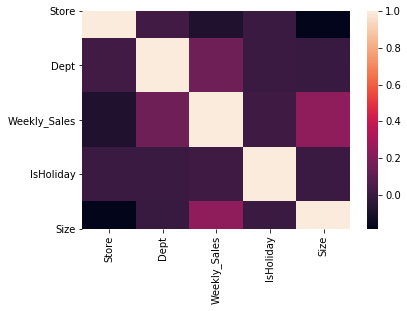

In [26]:
# Plotted the correlation using seaborn in a heatmap.
# Previous finding substantiated by the heatmap - very low correlation between various variables.
# Store number & Dept number are categorical variables / labels for the purpose of analysis, since they don't represent
# numerical information that can be used for analysis

sns.heatmap(df.corr())

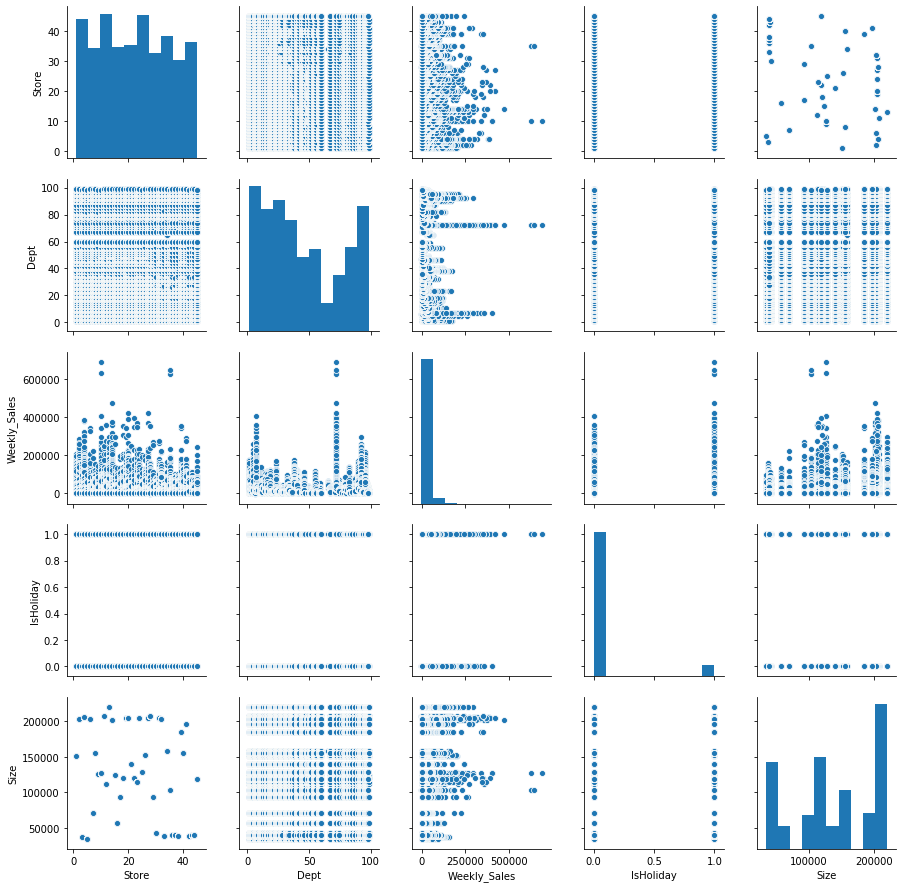

In [27]:
# Plotted all vairables in a pairplot to look for linear / polynomial relationships 

sns.pairplot(df)

In [28]:
# Used aggregation to calculate total weekly sales for all stores

df_sales_all_stores = df.groupby(by = ['Date'], as_index=False)[['Weekly_Sales']].sum()
df_sales_all_stores.head()

,Date,Weekly_Sales
0,2010-01-10,42239875.87
1,2010-02-04,50423831.26
2,2010-02-07,48917484.50
3,2010-02-19,48276993.78
4,2010-02-26,43968571.13


In [30]:
# Plotted Date & total weekly sales for all stores (calculated above). It looks like the sales are seasonal, with higher sales
# during the Holiday period - Nov to January

source = ColumnDataSource(df_sales_all_stores)
p = figure(plot_width=900, plot_height=300, title='Total Weekly Sales for all Stores', x_axis_label='Date',
           y_axis_label='Weekly Sales', x_axis_type="datetime")

# add a line renderer and a hover tool

p.line(x='Date', y='Weekly_Sales', source=source, color='navy', alpha=0.8, line_width=2)
hover = HoverTool()
hover.tooltips = [("Totals", "@Weekly_Sales{0,0}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results

show(p)

In [31]:
# Sorted dates in ascending order to find if there exists a weekly frequency in sales data?

a = df.groupby(by='Date', as_index=False)[['Weekly_Sales']].sum()
a.sort_values(by='Date', ascending = True)
a[:5]

# Finding: The dates are random with no fixed frequency. Also, the data for January 2010 begins on Jan 10th (mid-month)
# *WE WILL USE THIS INFORMATION LATER DURING DATA MODELLING*

,Date,Weekly_Sales
0,2010-01-10,42239875.87
1,2010-02-04,50423831.26
2,2010-02-07,48917484.50
3,2010-02-19,48276993.78
4,2010-02-26,43968571.13


In [32]:
a[-5:]

# Finding: The data for December 2012 is avaiable only until Dec 10th week (mid-month)
# *WE WILL USE THIS INFORMATION LATER DURING DATA MODELLING*

,Date,Weekly_Sales
138,2012-10-08,47403451.04
139,2012-10-19,45122410.57
140,2012-10-26,45544116.29
141,2012-11-05,46925878.99
142,2012-12-10,46128514.25


In [33]:
# Used aggregation to calculate Average sales by store size (since there was a weak correlation between
# Weekly_Sales & Size of the store). It looks like generaly the sales increase with the size of the store, however, it's
# not a linear graph, since some smaller and medium size stores have higher sales than some larger stores.

df_avg_sales_by_store_size = df.groupby(by='Size', as_index=False)[['Weekly_Sales']].mean()


source = ColumnDataSource(df_avg_sales_by_store_size)
p = figure(plot_width=900, plot_height=300, title='Average Sales by Store Size', x_axis_label='Store Size',
           y_axis_label='Sales')

# add a vertical bar renderer
p.vbar(x='Size', top='Weekly_Sales', source=source, width = 500, color='firebrick')

# add a hover tool
hover = HoverTool()
hover.tooltips = [("Average Sales", "@Weekly_Sales{int}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")
p.xaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results
show(p)

In [34]:
# Using aggregation to calculate average sales by Store & Store Size

df_avg_sales_by_store = df.groupby(by = ['Store','Size'], as_index=False)[['Weekly_Sales']].mean()
df_avg_sales_by_store.sort_values(by='Weekly_Sales', ascending=False).head()

# We see that the Top 5 Stores by Average Sales are Store number 19, 3, 13, 12 and 1 (in descending order)

,Store,Size,Weekly_Sales
19,20,203742,29508.301592
3,4,205863,29161.210415
13,14,200898,28784.851727
12,13,219622,27355.136891
1,2,202307,26898.070031


In [38]:
# Plotting Average Sales by Store number

source = ColumnDataSource(df_avg_sales_by_store)
p = figure(plot_width=900, plot_height=500, title='Average Sales by Store', y_axis_label='Store Number',
           x_axis_label='Sales')

# add a horizontal bar renderer
p.hbar(y='Store', right='Weekly_Sales', source=source, height=0.5, left=0, color="navy")

# add a hover tool
hover = HoverTool()
hover.tooltips = [("Store Number", "@Store{int}"),("Average Sales", "@Weekly_Sales{0,0}"),("Store Size","@Size{0 a}")]
p.add_tools(hover)

# format the axis
p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0,0")
p.xaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results
show(p)

In [39]:
# Using aggregation calculated Average Sales by Dept and plotted it using bokeh

df_avg_sales_by_dept = df.groupby(by=['Dept'], as_index=False)[['Weekly_Sales']].mean()


source = ColumnDataSource(df_avg_sales_by_dept)
p = figure(plot_width=900, plot_height=300, title='Average Sales by Dept', x_axis_label='Dept Number', y_axis_label='Sales')

# add a horizontal bar renderer
p.vbar(x='Dept', top='Weekly_Sales', source=source, width = 0.5, color='firebrick')

# add a hover tool
hover = HoverTool()
hover.tooltips = [("Dept","@Dept{int}"),("Average Sales", "@Weekly_Sales{0,0}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")
p.xaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results
show(p)

In [40]:
# Using aggregation to calculate Average Sales for Holiday / Not Holiday to see the effect of Holidays on Weekly Sales

df_avg_sales_isholiday = df.groupby(by=['IsHoliday'], as_index=False)[['Weekly_Sales']].mean()
df_avg_sales_isholiday.head()

,IsHoliday,Weekly_Sales
0,0,15901.445069
1,1,17035.823187


In [41]:
# Plotting average sales against IsHoliday shows that the average sales during Holidays are higher compared to sales during
# no holiday (1 indicates Holiday and 0 indicates no holiday)

source = ColumnDataSource(df_avg_sales_isholiday)
p = figure(plot_height=200, title='Average Sales by Holiday', x_axis_label='Avarage Sales',
           y_axis_label='Is Holiday')

# add horizonal bar renderers
p.hbar(y='IsHoliday', right='Weekly_Sales', source=source, height = 0.2, left=0, color='firebrick')

# add a hover tool
hover = HoverTool()
hover.tooltips = [("Is Holiday","@IsHoliday{int}"),("Average Sales", "@Weekly_Sales{int}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")
p.xaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results
show(p)

In [42]:
# Using aggregation calculated Average sales and Average Store Size by Store Type

df_avg_sales_store_type = df.groupby(by=['Type'], as_index = False)[['Size','Weekly_Sales']].mean()
df_avg_sales_store_type

# Stores belonging to Type A are the largest and have the highest sales, followed by Type B and Type C (Store Size as well as
# Average Sales)

,Type,Size,Weekly_Sales
0,A,182231.285486,20099.568043
1,B,101818.735827,12237.075977
2,C,40535.725286,9519.532538


In [43]:
# Plotted Average Sales by Store Type, with 'Average Store Size' in hover details

source = ColumnDataSource(df_avg_sales_store_type)
type = source.data['Type'].tolist()

p=figure(x_range=type, plot_height=300, toolbar_location=None, title="Average Sales by Store Type", x_axis_label='Store Type',
           y_axis_label='Average Sales')

# add vertical bars
p.vbar(x='Type', top='Weekly_Sales', width=0.5, source=source, legend='Type',
       line_color='white', fill_color=factor_cmap('Type', palette=Spectral6, factors=type))

# add hover information
hover = HoverTool()
hover.tooltips = [("Average Store Size","@Size{0,0}"),("Average Sales", "@Weekly_Sales{0,0}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")
p.xgrid.grid_line_color = None

# show results
show(p)

## Data Modelling

### Linear Regression Modelling

In [45]:
# Using statsmodels package to build a simple linear regression model to test a linear relationship between
# the dependent variable (Weekly Sales) and the independent variable (Date)

reg_model1 = smf.ols("Weekly_Sales ~  Date", data = df).fit()
model1.summary()

# From the OLS regression results we see that the R-squared value is extremely low (<<1), hence, indicating that
# this linear regression model is not a good fit for the data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     18.48
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:25:22   Log-Likelihood:            -4.8255e+06
No. Observations:              421570   AIC:                         9.651e+06
Df Residuals:                  421427   BIC:                         9.653e+06
Df Model:                         142                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 1.439e+04    417.985     34.431      0.000    1.36e+04    1.52e+04
Date[T.Timestamp('2010-02-04 00:00:00')]  2706.8398    590.419      4.585      0.000    1549.637    3864.042
Date[T.Timestamp('2010-02-07 00:00:00')]  2378.0119    592.032      4.017      0.000    1217.648    3538.376
Date[T.Timestamp('2010-02-19 00:00:00')]  1824.8784    589.032      3.098      0.002     670.394    2979.363
Date[T.Timestamp('2010-02-26 00:00:00')]   507.7692    590.319      0.860      0.390    -649.238    1664.776
Date[T.Timestamp('2010-03-09 00:00:00')]  1737.4941    591.575      2.937      0.003     578.025    2896.963
Date[T.Timestamp('2010-03-12 00:00:00')]  2532.2710    590.419      4.289      0.000    1375.069    3689.473
Date[T.Timestamp('2010-03-19 00:00:00')]   894.9930    590.719      1.515      0.130    -262.798    2052.784
Date[T.Timestamp('2010-03-26 00:00:00')]   584.1140    590.518      0.989      0.323    -573.284    1741.512
Date[T.Timestamp('2010-04-06 00:00:00')]  2855.1415    592.389      4.820      0.000    1694.077    4016.206
Date[T.Timestamp('2010-04-16 00:00:00')]   955.9325    590.669      1.618      0.106    -201.760    2113.625
Date[T.Timestamp('2010-04-23 00:00:00')]   860.3342    591.221      1.455      0.146    -298.442    2019.110
Date[T.Timestamp('2010-04-30 00:00:00')]   575.7286    591.879      0.973      0.331    -584.337    1735.794
Date[T.Timestamp('2010-05-02 00:00:00')]  2444.3415    590.120      4.142      0.000    1287.725    3600.958
Date[T.Timestamp('2010-05-03 00:00:00')]  1529.2352    590.669      2.589      0.010     371.543    2686.928
Date[T.Timestamp('2010-05-11 00:00:00')]  1233.4693    591.373      2.086      0.037      74.397    2392.542
Date[T.Timestamp('2010-05-14 00:00:00')]  1121.5939    591.778      1.895      0.058     -38.272    2281.460
Date[T.Timestamp('2010-05-21 00:00:00')]  1108.0848    592.338      1.871      0.061     -52.879    2269.049
Date[T.Timestamp('2010-05-28 00:00:00')]  2036.6689    592.542      3.437      0.001     875.304    3198.034
Date[T.Timestamp('2010-06-08 00:00:00')]  2184.9042    592.491      3.688      0.000    1023.640    3346.169
Date[T.Timestamp('2010-06-18 00:00:00')]  1889.2609    591.626      3.193      0.001     729.693    3048.829
Date[T.Timestamp('2010-06-25 00:00:00')]  1586.6344    592.032      2.680      0.007     426.270    2746.999
Date[T.Timestamp('2010-07-05 00:00:00')]  2150.9355    591.272      3.638      0.000     992.061    3309.810
Date[T.Timestamp('2010-07-16 00:00:00')]  1548.8949    592.850      2.613      0.009     386.927    2710.863
Date[T.Timestamp('2010-07-23 00:00:00')]   965.3351    591.727      1.631      0.103    -194.432    2125.102
Date[T.Timestamp('2010-07-30 00

In [47]:
# Using statsmodels package to build a simple linear regression model to test a linear relationship between
# the dependent variable (Weekly Sales) and the independent variable (Store Size). Store Size and Weekly Sales had
# the higest correlation among any 2 variables in this data (0.24 - Low correlation)

reg_model2 = smf.ols("Weekly_Sales ~  Size", data = df).fit()
reg_model2.summary()

# From the OLS regression results, we see that the R-squared value is still very low (<<1) indicating that this model is
# not a good fit for the data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                 2.665e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:26:03   Log-Likelihood:            -4.8139e+06
No. Observations:              421570   AIC:                         9.628e+06
Df Residuals:                  421568   BIC:                         9.628e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3565.0510     83.283     42.806      0.000    3401.819    3728.283
Size           0.0908      0.001    163.240      0.000       0.090       0.092
==============================================================================
Omnibus:                   308559.003   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9589455.593
Skew:                           3.195   Prob(JB):                         0.00
Kurtosis:                      25.474   Cond. No.                     3.68e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# Using statsmodels package to build a multiple linear regression model to test a linear relationship between
# the dependent variable (Weekly Sales) and the independent variables (Store Size & IsHoliday)

reg_model3 = smf.ols("Weekly_Sales ~  Size + IsHoliday", data = df).fit()
reg_model3.summary()

# From the OLS regression results, we see that the R-squared value is again very low (<<1) indicating that this model is also
# not a good fit for the data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                 1.336e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:26:26   Log-Likelihood:            -4.8138e+06
No. Observations:              421570   AIC:                         9.628e+06
Df Residuals:                  421567   BIC:                         9.628e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3486.5228     83.792     41.609      0.000    3322.293    3650.753
Size           0.0908      0.001    163.249      0.000       0.090       0.092
IsHoliday   1121.5378    132.631      8.456      0.000     861.586    1381.490
==============================================================================
Omnibus:                   308137.759   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9511291.721
Skew:                           3.191   Prob(JB):                         0.00
Kurtosis:                      25.377   Cond. No.                     5.88e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
# Using statsmodels package to build a polynomial regression model to test a polynomial relationship between
# the dependent variable (Weekly Sales) and the independent variable (Store Size)

reg_model4 = smf.ols("Weekly_Sales ~  + np.power(Size, 2) + np.power(Size,3) + np.power(Size,4) + np.power(Size,5)",
                     data=df).fit()
reg_model4.summary()

# The R-squared value continues to be very low (<<1), indicating that a regression model might not be a good fit for this data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     7270.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:27:00   Log-Likelihood:            -4.8162e+06
No. Observations:              421570   AIC:                         9.632e+06
Df Residuals:                  421566   BIC:                         9.632e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.109e-16    1.3e-18    162.143      0.000    2.08e-16    2.13e-16
np.power(Size, 2)  1.487e-06   9.17e-09    162.143      0.000    1.47e-06    1.51e-06
np.power(Size, 3) -4.696e-12   4.71e-14    -99.634      0.000   -4.79e-12    -4.6e-12
np.power(Size, 4)  2.853e-16   6.29e-18     45.344      0.000    2.73e-16    2.98e-16
np.power(Size, 5)  1.376e-16   6.74e-18     20.416      0.000    1.24e-16    1.51e-16
==============================================================================
Omnibus:                   296131.757   Durbin-Watson:                   0.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8708024.067
Skew:                           3.021   Prob(JB):                         0.00
Kurtosis:                      24.430   Cond. No.                     1.48e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+19. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

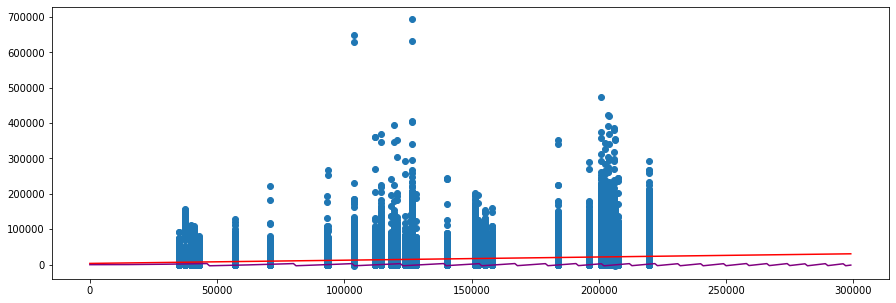

In [52]:
# Plotted model 2 & model 4 in a graph using matplotlib.pyplot
# model 2 - Simple linear regression between Weekly Sales & Store Size to predict Weekly Sales
# model 4 - Polynomial (quintic) regression between Weekly Sales & Store Size to predict Weekly Sales

weekly_sales_df = pd.DataFrame({"Size": np.arange(0, 300000, 1000)})
weekly_sales_df['Linear Prediction Size Variable'] = reg_model2.predict(weekly_sales_df)
weekly_sales_df['Polynomial Prediction Size Variable'] = reg_model4.predict(weekly_sales_df)

plt.figure(figsize=(15,5))
plt.scatter(df['Size'], df['Weekly_Sales'])
plt.plot(weekly_sales_df['Size'], weekly_sales_df['Linear Prediction Size Variable'], color = 'red')
plt.plot(weekly_sales_df['Size'], weekly_sales_df['Polynomial Prediction Size Variable'], color = 'purple')

# The graphs substantiate that the regression models are not a good fit for this dataset

### SARIMA Modelling - Time Series Forecasting

Seasonal Autoregressive Integrated Moving Average Model

Since Regression models were not a good fit for this dataset, and the dataset seemed to have seasonality based on the graph, I looked at other options for time series forecasting, and came across SARIMA modelling

In [53]:
# Created a new dataframe df1 which aggregates Weekly Sales by Date

df1 = df.groupby(by='Date')[["Weekly_Sales"]].sum()
df1.index = pd.to_datetime(df1.index)
df1.head()

,Weekly_Sales
Date,
2010-01-10,42239875.87
2010-02-04,50423831.26
2010-02-07,48917484.50
2010-02-19,48276993.78
2010-02-26,43968571.13


In [54]:
# Checked the data types in the new dataframe

df1.dtypes

Weekly_Sales    float64
dtype: object

In [55]:
# As we found previously that the dates do not have a fixed frequency, we will resample the data to Monthly frequency,
# since time series forecasting using ARIMA / SARIMA models requires the data to have a fixed frequency

monthly_df1 = df1.Weekly_Sales.resample('M').sum()
monthly_df1 = pd.DataFrame(monthly_df1)
monthly_df1.rename(columns = {'Weekly_Sales':'Monthly_Sales'}, inplace = True) 
monthly_df1.head()

,Monthly_Sales
Date,
2010-01-31,4.223988e+07
2010-02-28,1.915869e+08
2010-03-31,1.862262e+08
2010-04-30,1.838118e+08
2010-05-31,2.806119e+08


In [56]:
# Plotting the total monthly sales for all stores (calculated above)

source = ColumnDataSource(monthly_df1)
p = figure(plot_width=900, plot_height=300, title='Total Monthly Sales for all Stores', x_axis_label='Date',
           y_axis_label='Monthly Sales', x_axis_type="datetime")

# add a line renderer
p.line(x='Date', y='Monthly_Sales', source=source, line_width=2)

# Add hover details
hover = HoverTool()
hover.tooltips = [("Total Sales", "@Monthly_Sales{0 a}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results
show(p)

In [57]:
monthly_df1.describe()

,Monthly_Sales
count,3.600000e+01
mean,1.871450e+08
std,6.172724e+07
min,4.223988e+07
25%,1.688588e+08
50%,1.845623e+08
75%,2.256898e+08
max,3.235716e+08


In [58]:
# We also found during the exploratory analysis phase that the data for Jan 2010 & Dec 2012 starts/ends mid-month, which is 
# why we will discard Jan 2010 & Dec 2012 data
# Nov 2012 data looks like an outlier too, so we will discard that as well

monthly_df1 = monthly_df1[1:-2]
monthly_df1

,Monthly_Sales
Date,
2010-02-28,1.915869e+08
2010-03-31,1.862262e+08
2010-04-30,1.838118e+08
2010-05-31,2.806119e+08
2010-06-30,1.424361e+08
2010-07-31,1.842664e+08
2010-08-31,1.845381e+08
2010-09-30,1.797041e+08
2010-10-31,2.311201e+08


In [59]:
# Plotting the total monthly sales for all stores (calculated above), after discarding Jan 2010, Nov 2012 & Dec 2012 data

source = ColumnDataSource(monthly_df1)
p = figure(plot_width=900, plot_height=300, title='Total Monthly Sales for all Stores', x_axis_label='Date',
           y_axis_label='Monthly Sales', x_axis_type="datetime")

# add a line renderer
p.line(x='Date', y='Monthly_Sales', source=source, line_width=2)

# Add hover details
hover = HoverTool()
hover.tooltips = [("Total Sales", "@Monthly_Sales{0 a}")]
p.add_tools(hover)

p.left[0].formatter.use_scientific = False
p.yaxis.formatter=NumeralTickFormatter(format="0 a")

# show the results
show(p)

<Figure size 432x288 with 0 Axes>

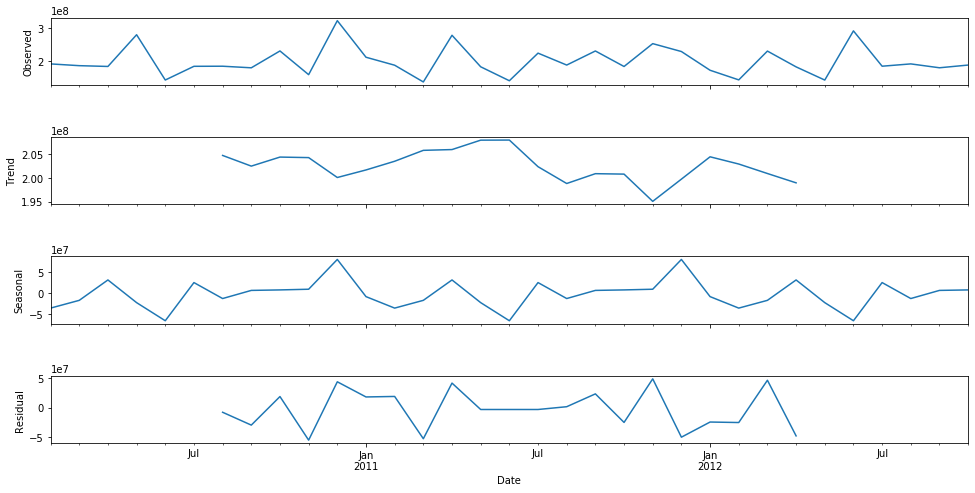

In [60]:
# Using statsmodel seasonal_decompose to visualize seasonality and trend. Since the data is monthly, freq = 12

decomposition = seasonal_decompose(monthly_df1, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [61]:
# Created a copy of monthly_df1 to test if the data is stationary (data is not a function of time) using the adfuller test

monthly_df2 = monthly_df1.copy()
result1 = adfuller(monthly_df2['Monthly_Sales'], autolag='AIC')
print('ADF Statistic:{}'.format(result1[0]))
print('p-value:{}'.format(result1[1]))
print('#Lags Used:{}'.format(result1[2]))
print('Number of observations used:{}'.format(result1[3]))
for key, value in result1[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# The results of Dickey-Fuller test show that the ADF statistic is higher than all 3 critical values, so we can say that
# the data is NOT stationary

ADF Statistic:-0.5680426333724123
p-value:0.8780408253140108
#Lags Used:10
Number of observations used:22
Critial Values:
   1%, -3.769732625845229
Critial Values:
   5%, -3.005425537190083
Critial Values:
   10%, -2.6425009917355373


In [62]:
# Testing the stationarity of the data after one order of differencing

monthly_df2['first_difference'] = monthly_df2 - monthly_df2.shift(1)

result2 = adfuller(monthly_df2['first_difference'].dropna(inplace=False), autolag='AIC')
print('ADF Statistic:{}'.format(result2[0]))
print('p-value:{}'.format(result2[1]))
print('#Lags Used:{}'.format(result2[2]))
print('Number of observations used:{}'.format(result2[3]))
for key, value in result2[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# The results of Dickey-Fuller test show that the ADF statistic is lower than 5% critical value, so we can say with
# 95% confidence that the first order differenced data is stationary

ADF Statistic:-3.361857310056574
p-value:0.012329945893517992
#Lags Used:10
Number of observations used:21
Critial Values:
   1%, -3.7883858816542486
Critial Values:
   5%, -3.013097747543462
Critial Values:
   10%, -2.6463967573696143


In [63]:
# Added a new column with second order for differencing

monthly_df2['second_difference'] = monthly_df1.diff(2)
monthly_df2.head()

,Monthly_Sales,first_difference,second_difference
Date,,,
2010-02-28,1.915869e+08,NaN,NaN
2010-03-31,1.862262e+08,-5.360659e+06,NaN
2010-04-30,1.838118e+08,-2.414432e+06,-7775091.20
2010-05-31,2.806119e+08,9.680009e+07,94385662.33
2010-06-30,1.424361e+08,-1.381758e+08,-41375707.83


In [64]:
# Testing the stationarity of the data after two orders of differencing

monthly_df2['second_difference'] = monthly_df2 - monthly_df2.shift(2)

result3 = adfuller(monthly_df2['second_difference'].dropna(inplace=False), autolag='AIC')
print('ADF Statistic:{}'.format(result3[0]))
print('p-value:{}'.format(result3[1]))
print('#Lags Used:{}'.format(result3[2]))
print('Number of observations used:{}'.format(result3[3]))
for key, value in result3[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# The results of Dickey-Fuller test show that the ADF statistic is lower than 1% critical value, so we can say with
# 99% confidence that the data is stationary. Since the first order of differencing gave a near stationary data with
# 95% confidence, the second order of difference will lead to overfitting of the model

ADF Statistic:-5.787708897302296
p-value:4.954744178432349e-07
#Lags Used:9
Number of observations used:21
Critial Values:
   1%, -3.7883858816542486
Critial Values:
   5%, -3.013097747543462
Critial Values:
   10%, -2.6463967573696143


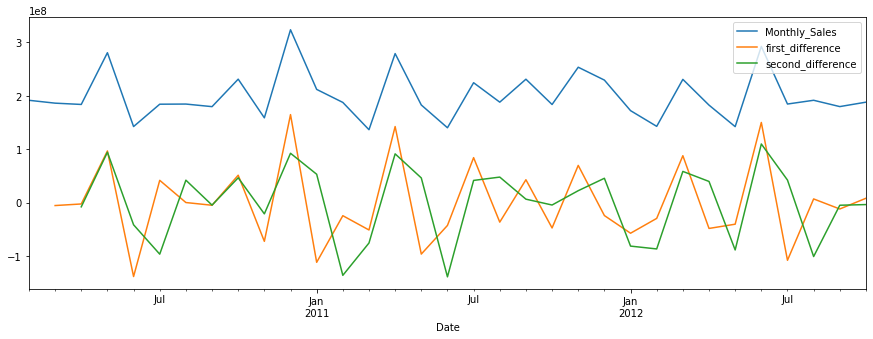

In [67]:
# Plotted the monthly sales data with first order differenced and second order differenced data

monthly_df2.plot(figsize=(15,5))
plt.show()

As shown in the Ad-fuller test, the data is stationary after first order differencing. However, the same will be substantiated below in the estimation of the parameters for SARIMAX model using itertools

In [69]:
# Using itertools to iterate through various combinations of p, d & q parameters to determine the combination that yields
# the lowest AIC value
# The AIC measures how well a model fits the data while taking into account the overall complexity of the model

warnings.filterwarnings("ignore")

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_df1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# We see that the values (1,1,1)x(1,1,0)12 for (p,d,q)x(P,D,Q)S parameters yields the lowest AIC value

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1317.8337272647043
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:783.9416818868718
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:819.8023688414318
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:354.17546982748587
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1262.110565717111
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:739.4139274233676
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:850.085041772416
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:351.562021999487
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1215.3448357379768
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:766.829239108632
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:782.8118548186252
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:324.5239188193111
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1150.5881226750148
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:713.0822023361094
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:767.0463518796871
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:319.88805231676815
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1254.308607549413
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:777.8045145826122
ARIMA(1,

In [74]:
# Using the paramter values calculated above, generated the data model

final_mod = sm.tsa.statespace.SARIMAX(monthly_df1, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_invertibility=False)
final_res = mod.fit()
print(final_res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Monthly_Sales   No. Observations:                   33
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -392.362
Date:                            Sat, 04 Apr 2020   AIC                            792.725
Time:                                    16:44:26   BIC                            796.708
Sample:                                02-28-2010   HQIC                           793.502
                                     - 10-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3074      0.329     -0.935      0.350      -0.952       0.337
ma.L1         -0.4110      0.251   

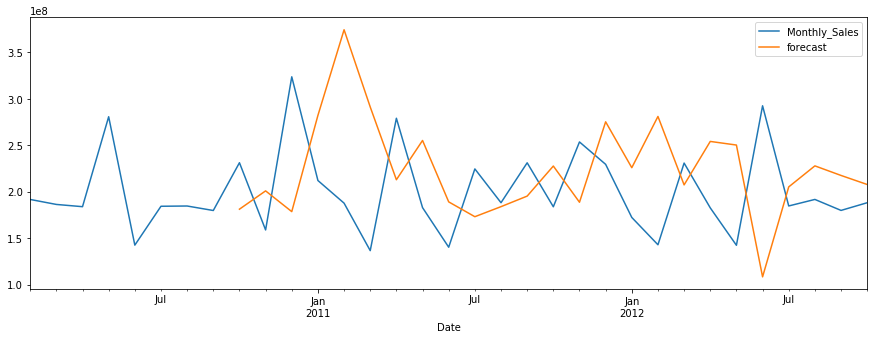

In [75]:
# Plotted the data and forecast using the SARIMA data model

monthly_df3 = monthly_df1.copy()
monthly_df3['forecast'] = final_res.predict(start = '2010-10-31', end= '2012-12-31')  
monthly_df3[['Monthly_Sales', 'forecast']].plot(figsize=(15, 5))

### Model Validation

In [76]:
# Define Train & Test Data sets

tr_start, tr_end = '2010-01-01','2012-03-31'
te_start, te_end = '2012-04-01', '2012-12-31'
train = monthly_df1['Monthly_Sales'][tr_start:tr_end].dropna()
test = monthly_df1['Monthly_Sales'][te_start:te_end].dropna()

                                 Statespace Model Results                                 
Dep. Variable:                      Monthly_Sales   No. Observations:                   26
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -253.727
Date:                            Sat, 04 Apr 2020   AIC                            515.454
Time:                                    17:11:27   BIC                            517.714
Sample:                                02-28-2010   HQIC                           514.989
                                     - 03-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4069      0.517     -0.787      0.431      -1.420       0.606
ma.L1         -0.2113      0.400   

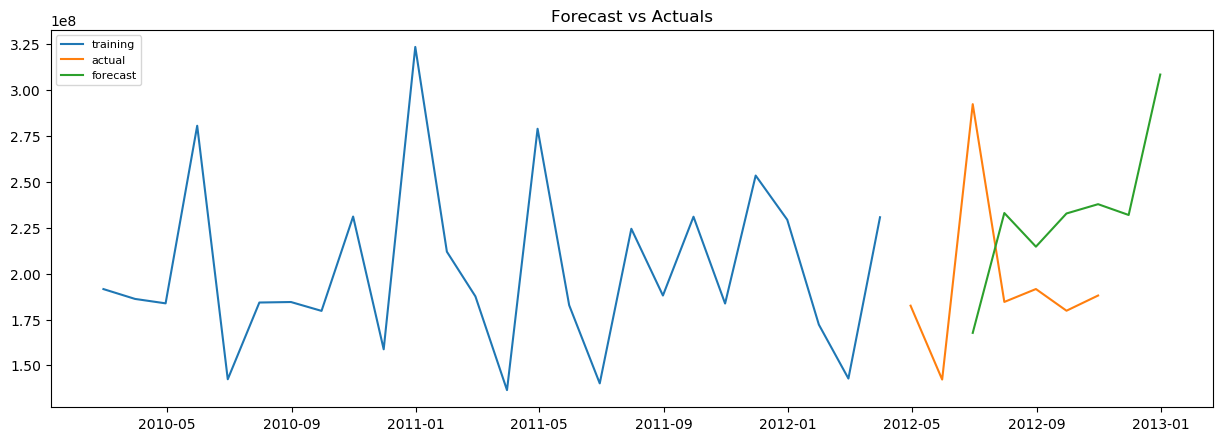

In [103]:
model_train = sm.tsa.statespace.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_invertibility=False)
res_train = model_train.fit()
print(res_train.summary())

prediction = res_train.predict(tr_end, te_end)[3:]
print(res_train.predict(tr_end, te_end)[1:])

print('SARIMA Model MSE:{}'.format(mean_squared_error(test, pred)))

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The Mean Square Error as calculated above is very high, which indicates that the model needs further fitting

In [109]:
# Added new monthly time periods to the data frame

pred_monthly_df1 = monthly_df1.copy()

from dateutil.relativedelta import relativedelta, MO
start = datetime.strptime("2012-12-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= monthly_df1.columns)
pred_monthly_df1 = pd.concat([pred_monthly_df1, future])

pred_monthly_df1[-5:]

,Monthly_Sales
2013-07-31,NaN
2013-08-31,NaN
2013-09-30,NaN
2013-10-31,NaN
2013-11-30,NaN


2012-12-31    3.085206e+08
2013-01-31    2.223594e+08
2013-02-28    1.956450e+08
2013-03-31    2.094704e+08
2013-04-30    2.903830e+08
2013-05-31    2.526152e+08
2013-06-30    1.820001e+08
2013-07-31    2.574215e+08
2013-08-31    2.294657e+08
2013-09-30    2.608071e+08
2013-10-31    2.379531e+08
2013-11-30    2.723815e+08
2013-12-31    2.952854e+08
Freq: M, dtype: float64


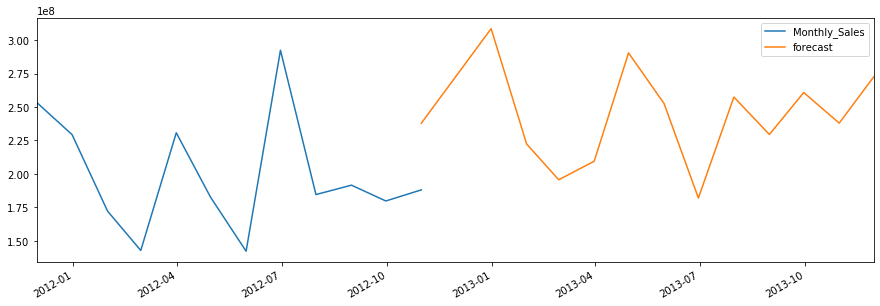

In [118]:
# Predicted sales for the next 12 months

forecast = res_train.predict(start = '2012-12-31', end= '2013-12-31')  
print(forecast)
pred_monthly_df1['forecast'] = res_train.predict(start = '2012-10-31', end= '2013-12-31')  
pred_monthly_df1[['Monthly_Sales', 'forecast']].ix[-24:].plot(figsize=(15, 5))

# Thank you!